# Gradient Boosting: a practical guide

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

## An example: the california housing dataset

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import median_absolute_error


calhousing = fetch_california_housing()

X, y = calhousing.data, calhousing.target

In [3]:
print(calhousing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [4]:
print(calhousing.feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1000, random_state=0)

Let's start with a quick baseline model: linear regression (aka. Ordinary Least Squares):

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

%time lm = LinearRegression().fit(X_train, y_train)

CPU times: user 15.3 ms, sys: 36.3 ms, total: 51.7 ms
Wall time: 26.1 ms


In [7]:
print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train, lm.predict(X_train)),
       median_absolute_error(y_test, lm.predict(X_test))))

train error: 0.413, test error: 0.419


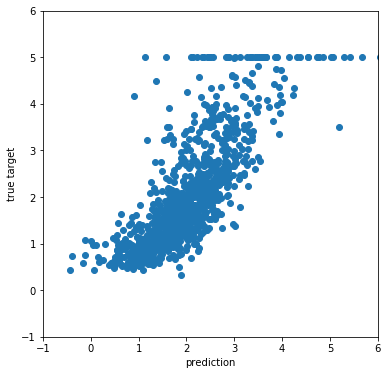

In [8]:
def scatter_predictions(y_pred, y_true):
    plt.figure(figsize=(6, 6))
    plt.xlabel('prediction')
    plt.ylabel('true target')
    plt.xlim(-1, 6)
    plt.ylim(-1, 6)
    plt.scatter(y_pred, y_true)
    
scatter_predictions(lm.predict(X_test), y_test)

This is pretty bad: the errors (off-diagonal predictions) seems to be heteroschedastic and there is a saturation effect with many samples with `y_true == 5`. Let's check:

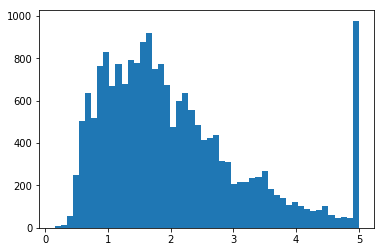

In [9]:
plt.hist(y_train, bins=50);

We can filter out the "anomalies" and make the target variable marginal distribution more "Gaussian" by taking the log:

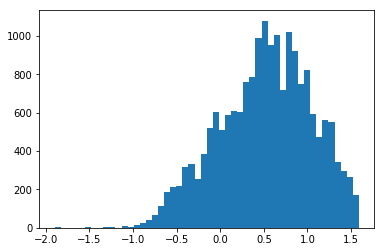

In [10]:
plt.hist(np.log(y_train[y_train < 4.9]), bins=50);

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


lm2 = make_pipeline(StandardScaler(), LinearRegression())
%time lm2.fit(X_train[y_train < 4.9], np.log(y_train[y_train < 4.9]))

CPU times: user 23.3 ms, sys: 11.6 ms, total: 34.9 ms
Wall time: 11.8 ms


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [12]:
print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train[y_train < 4.9],
                             np.exp(lm2.predict(X_train[y_train < 4.9]))),
       median_absolute_error(y_test[y_test < 4.9],
                             np.exp(lm2.predict(X_test[y_test < 4.9])))))

train error: 0.325, test error: 0.340


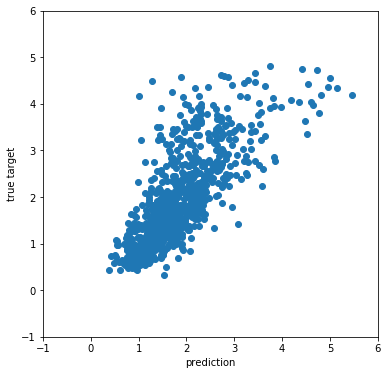

In [13]:
scatter_predictions(
    np.exp(lm2.predict(X_test[y_test < 4.9])),
    y_test[y_test < 4.9])

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_union

plm = make_pipeline(
    StandardScaler(),
    make_union(
        FunctionTransformer(lambda x: x, validate=True),
        PolynomialFeatures(degree=5)
    ),
    LinearRegression())

%time plm.fit(X_train[y_train < 4.9], np.log(y_train[y_train < 4.9]))

print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train[y_train < 4.9],
                             np.exp(plm.predict(X_train[y_train < 4.9]))),
       median_absolute_error(y_test[y_test < 4.9],
                             np.exp(plm.predict(X_test[y_test < 4.9])))))

CPU times: user 7.48 s, sys: 1.45 s, total: 8.93 s
Wall time: 2.99 s
train error: 0.205, test error: 0.228


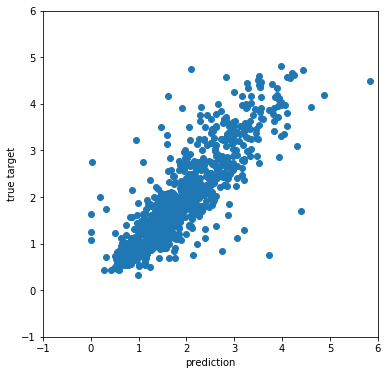

In [15]:
scatter_predictions(
    np.exp(plm.predict(X_test[y_test < 4.9])),
    y_test[y_test < 4.9])

In [16]:
from sklearn.neural_network import MLPRegressor

mlp = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(100, 10, 10), activation='relu'),
)
%time mlp.fit(X_train[y_train < 4.9], np.log(y_train[y_train < 4.9]))

print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train[y_train < 4.9],
                             np.exp(mlp.predict(X_train[y_train < 4.9]))),
       median_absolute_error(y_test[y_test < 4.9],
                             np.exp(mlp.predict(X_test[y_test < 4.9])))))

CPU times: user 8.37 s, sys: 80.4 ms, total: 8.45 s
Wall time: 8.35 s
train error: 0.201, test error: 0.212


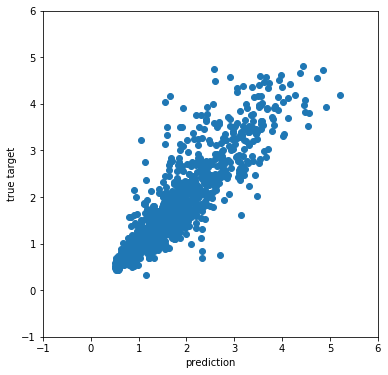

In [17]:
scatter_predictions(
    np.exp(mlp.predict(X_test[y_test < 4.9])),
    y_test[y_test < 4.9])

In [18]:
gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=8, min_samples_leaf=20,
                                n_estimators=100, loss='huber')
%time gbr.fit(X_train, y_train)
print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train, gbr.predict(X_train)),
       median_absolute_error(y_test, gbr.predict(X_test))))

CPU times: user 6.65 s, sys: 56 ms, total: 6.71 s
Wall time: 6.67 s
train error: 0.135, test error: 0.187


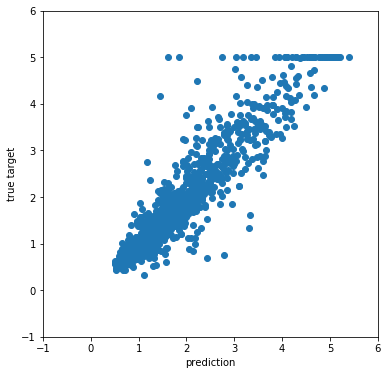

In [19]:
scatter_predictions(gbr.predict(X_test), y_test)

In [20]:
from pickle import dumps
print("Model size: %0.1f MB" % (len(dumps(gbr)) / 1e6))

Model size: 1.4 MB


In [21]:
%timeit gbr.predict(X_test[:100])

696 µs ± 30.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1)
%time rfr.fit(X_train, y_train)
print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train, rfr.predict(X_train)),
       median_absolute_error(y_test, rfr.predict(X_test))))

CPU times: user 17.5 s, sys: 76.2 ms, total: 17.6 s
Wall time: 5.14 s
train error: 0.074, test error: 0.196


In [23]:
print("Model size: %0.1f MB" % (len(dumps(rfr)) / 1e6))

Model size: 152.2 MB


In [24]:
%timeit rfr.predict(X_test[:100])

107 ms ± 4.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### New Histogram-based Gradient Boosting Trees

In [25]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [26]:
hgbr = HistGradientBoostingRegressor(min_samples_leaf=20, max_leaf_nodes=256,
                                     max_iter=100)
%time hgbr.fit(X_train, y_train)

CPU times: user 12.1 s, sys: 256 ms, total: 12.4 s
Wall time: 3.51 s


HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                              loss='least_squares', max_bins=256,
                              max_depth=None, max_iter=100, max_leaf_nodes=256,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=None, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0)

In [27]:
print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train, gbr.predict(X_train)),
       median_absolute_error(y_test, gbr.predict(X_test))))

train error: 0.135, test error: 0.187


In [28]:
print("Model size: %0.1f MB" % (len(dumps(hgbr)) / 1e6))

Model size: 2.4 MB


In [29]:
%timeit hgbr.predict(X_test[:100])

2.45 ms ± 302 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Early stopping

In [30]:
hgbr = HistGradientBoostingRegressor(min_samples_leaf=20, max_leaf_nodes=256,
                                     n_iter_no_change=5, validation_fraction=0.1,
                                     scoring="loss", max_iter=10000)
%time hgbr.fit(X_train, y_train)

CPU times: user 10.3 s, sys: 101 ms, total: 10.4 s
Wall time: 2.91 s


HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                              loss='least_squares', max_bins=256,
                              max_depth=None, max_iter=10000,
                              max_leaf_nodes=256, min_samples_leaf=20,
                              n_iter_no_change=5, random_state=None,
                              scoring='loss', tol=1e-07,
                              validation_fraction=0.1, verbose=0)

In [31]:
print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train, gbr.predict(X_train)),
       median_absolute_error(y_test, gbr.predict(X_test))))

train error: 0.135, test error: 0.187


In [32]:
hgbr.n_iter_

86

In [33]:
print("Model size: %0.1f MB" % (len(dumps(hgbr)) / 1e6))

Model size: 2.0 MB


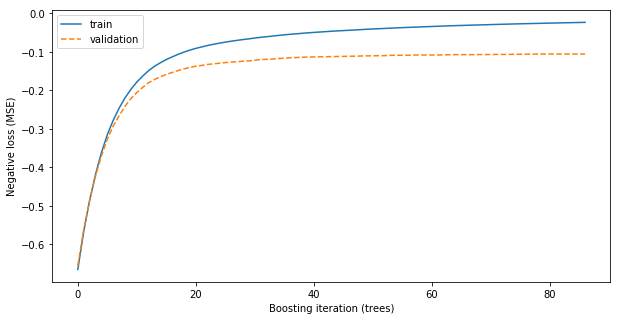

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hgbr.train_score_, label="train")
ax.plot(hgbr.validation_score_, "--", label="validation")
ax.set_xlabel("Boosting iteration (trees)")
ax.set_ylabel("Negative loss (MSE)")
ax.legend();

### Explaining what the model learned

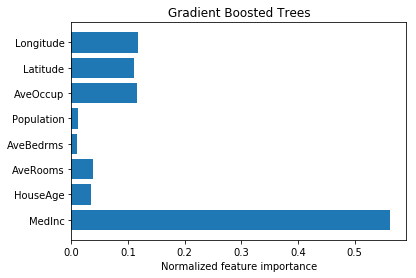

In [35]:
plt.barh(np.arange(X_train.shape[1]), gbr.feature_importances_,
         tick_label=calhousing.feature_names)
plt.xlabel("Normalized feature importance")
plt.title("Gradient Boosted Trees");

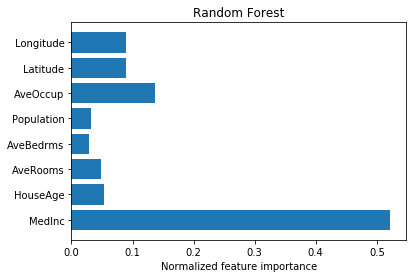

In [36]:
plt.barh(np.arange(X_train.shape[1]), rfr.feature_importances_,
         tick_label=calhousing.feature_names)
plt.xlabel("Normalized feature importance")
plt.title("Random Forest");

**WARNING**: tree-based importance is biased towards high cardinality features (such as continuous  numerical features). In many cases it is therefore recommended to use permutation based feature importances: https://christophm.github.io/interpretable-ml-book/feature-importance.html

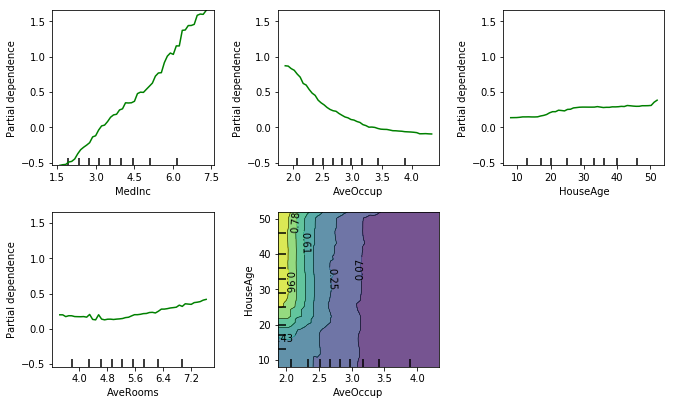

In [37]:
from sklearn.inspection.partial_dependence import plot_partial_dependence

features = [0, 5, 1, 2, (5, 1)]

plot_partial_dependence(gbr, X_train, features,
                        feature_names=calhousing.feature_names,
                        n_jobs=-1, grid_resolution=50,
                        fig=plt.figure(figsize=(10, 9)))
fig.suptitle('Partial dependence of house value on nonlocation features\n'
             'for the California housing dataset');

## Tricks

### Warm started models

In [38]:
X_train_small, X_val, y_train_small, y_val = train_test_split(
    X_train, y_train, train_size=5000, test_size=1000)

val_errors = []
train_errors = []


gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=8,
                                min_samples_leaf=3, n_estimators=1)

gbr.fit(X_train_small, y_train_small)

train_error = median_absolute_error(y_train, gbr.predict(X_train))
val_error = median_absolute_error(y_test, gbr.predict(X_test))

train_errors.append(train_error)
val_errors.append(val_error)

print("train error: %0.3f, test error: %0.3f" % (train_error, val_error)) 

train error: 0.695, test error: 0.763


In [39]:
for i in range(100):
    gbr.set_params(warm_start=True, n_estimators=len(gbr.estimators_) + 1)
    gbr.fit(X_train_small, y_train_small)
    train_error = median_absolute_error(y_train, gbr.predict(X_train))
    val_error = median_absolute_error(y_test, gbr.predict(X_test))

    train_errors.append(train_error)
    val_errors.append(val_error)
    if (i + 2) % 10 == 0:
        print("n_trees=%d, train error: %0.3f, test error: %0.3f"
              % (len(gbr.estimators_), train_error, val_error)) 

n_trees=10, train error: 0.412, test error: 0.444
n_trees=20, train error: 0.281, test error: 0.300
n_trees=30, train error: 0.226, test error: 0.250
n_trees=40, train error: 0.203, test error: 0.225
n_trees=50, train error: 0.194, test error: 0.219
n_trees=60, train error: 0.188, test error: 0.216
n_trees=70, train error: 0.184, test error: 0.217
n_trees=80, train error: 0.180, test error: 0.217
n_trees=90, train error: 0.176, test error: 0.216
n_trees=100, train error: 0.172, test error: 0.214


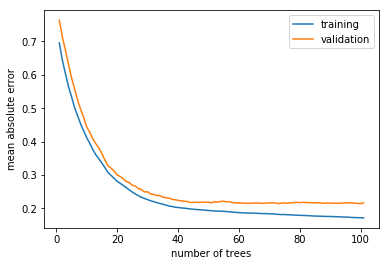

In [40]:
tree_indices = np.arange(len(val_errors)) + 1
plt.plot(tree_indices, train_errors, label='training')
plt.plot(tree_indices, val_errors, label='validation')
plt.xlabel('number of trees')
plt.ylabel('mean absolute error')
plt.legend(loc='best');

### Early stopping with custom iteration loop

In [41]:
patience = 5
gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=8, min_samples_leaf=3,
                                n_estimators=1, warm_start=True)

best_error = np.inf

for i in range(100):
    gbr.set_params(n_estimators=i + 1)
    gbr.fit(X_train_small, y_train_small)
    val_error = median_absolute_error(y_test, gbr.predict(X_test))
    if val_error < best_error:
        best_error = val_error
    else:
        patience -= 1
        if patience < 0:
            print('Converged at tree #%d' % (i + 1))
            break

Converged at tree #51


### Randomized parameter search with early stopping

This feature is being implemented directly in scikit-learn as part of [PR #5689](https://github.com/scikit-learn/scikit-learn/pull/5689).

Important hyper-parameters:

- `loss`
- `n_estimators` / `max_iter`
- `max_depth` (typically much smaller than for random forests) or `max_leaf_nodes`
- `min_samples_leaf` (help reduce the trees / model size and prediction speed)

### Probability calibration for classification confidence

Motivation:

- For realtime bidding: bid ~= CTR * expected revenue per click. CTR is a likelihood of clicking and can be estimated by the confidence level of the model.

- For a recommender system, it might be interesting to put a threshold on the number of items you recommend to a specific user in a specific context: better make 1 or 2 good recommendations than 10 recommendations with 9 garbage items. In order for this threshold to stay meaningful when you change the way you train the models, it might be a good idea to calibrate the model confidence level.

`GradientBoostingClassifier` has a `predict_proba` method but what it outputs tends to be mis-calibrated by default (similar to Support Vector Machines). It might be necessary to use Platt-scaling or Isotonic regression to recalibrate the model via cross-validation.

See: http://scikit-learn.org/stable/modules/calibration.html

### Categorical features encoded as integers

One-hot encoding is pretty useless for tree-based models (at least in scikit-learn). Contrary to other models it's pretty safe and much more efficient to use integer based encoding for instance using pandas:

```python
    >>> categorical_data.apply(lambda x: pd.factorize(x)[0])
```

alternatively you can use scikit-learn's [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

## Limitations

###  Regression with homogeneous feature interactions

Trees required to approximate X1−X2:

10 trees:

<img 
  width="50%"
  src="http://nbviewer.jupyter.org/github/pprett/pydata-gbrt-tutorial/blob/master/func_approx_minus_2.png" />
  
1000 trees:

<img 
  width="50%"
  src="http://nbviewer.jupyter.org/github/pprett/pydata-gbrt-tutorial/blob/master/func_approx_minus_3.png" />
  
Credits: https://github.com/pprett/pydata-gbrt-tutorial

### Multiclass classification

The training time, model size and prediction latency of Gradient Boosted Trees scale linearly with the number of classes...

The following are possibly better models for multiclass classification with a large number of classes:

- Random Forests
- Linear models: multi-nomial logistic regression: might require extensive feature engineering to model non-linear interactions in original space. The nystroem method or polynomial features migth be useful in that case.
- Neural Networks (MLP)

### High-dimensional feature spaces

GBRT models tend to work better on lower dimensional space (typically less than 500 features). Using feature importances or other feature selection strategies might help focus the feature engineering effort. But it cannot deal with very high dim bag of words feature for text classification for instance.

For very high-dimensional data, linear models will be much faster to train and possibly yield much better results. GBRT models can still be useful to blend predictions of other models, for instance:

- free text fields in database columns + few numeric or categorical fields
- train one TF-IDF (Bag of Words features) + logistic regression model per free-text field
- train a GBRT model that uses logistic regression models' probabilistic predictions concatenated with numerical and (integer coded) categorical fields to compute the final predictions.

## XGBoost and LightGBM

XGBoost and LightGBM provide a more efficient implementation and notably supports multi-threading via a scikit-learn compatible interface. 

They also support out-of-core and distributed model fitting although via a different API.

The new Histogram-based model of scikit-learn should be computationally competitive but (on single machine multithreads) but do not have all their features yet.

In [42]:
from xgboost import XGBRegressor

xgbr = XGBRegressor(learning_rate=0.1, max_depth=8, n_estimators=100)
%time xgbr.fit(X_train, y_train)
print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train, xgbr.predict(X_train)),
       median_absolute_error(y_test, xgbr.predict(X_test))))

CPU times: user 3.51 s, sys: 801 µs, total: 3.51 s
Wall time: 3.51 s
train error: 0.130, test error: 0.193


In [43]:
%timeit xgbr.predict(X_test[:100])

1.2 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [44]:
print("Model size: %0.1f MB" % (len(dumps(xgbr)) / 1e6))

Model size: 1.3 MB
